<div style="text-align: right"> Wyatt Walsh, Joshua Sanchez, Maxwell Buchholz, Jared Gonzales, Sung Won Seo</div>
<div style="text-align: right"> May 8, 2019</div>


## <center>IEOR 165 Final Project</center>

## This project consists of two parts. Part 1 is an exploration into linear regression and regularization. Part 2 delves  into support vector machines. Each part consists of code that solves the various techniques, plots, and tables.

### Part 1

First we must import the necessary libraries into our notebook. 

In [2]:
#Import statements
import numpy as np
from math import *
import pandas as pd 

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from sklearn import linear_model

Then, we go about loading our data into a PANDAS DataFrame and doing basic cleaning.

In [3]:
#Loading in data and viewing first few rows
wine_data = pd.read_csv('winequality-red.csv', sep = ';')
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


We create a function to calculate the variance inflation factors for each predictor. This is in order to examine the multicollinearity of our data. It is generally agreed upon that VIFs higher than 5 demonstrate a significant amount of multicollinearity.

In [4]:
def VIF(df):
    """Computes the VIF for the X data in the dataframe. ...
    *"variance inflation factor (VIF) is the ratio of variance in a model with multiple terms...
    divided by the variance of a model with one term alone. It quantifies the severity of multicollinearity ...
    in an ordinary least squares regression analysis. It provides an index that measures how much the variance ...
    of an estimated regression coefficient ais increased because of collinearity"
    "A rule of thumb is that if VIF B[i]>10} then multicollinearity is high; a cutoff of 5 is also commonly used"
    """
    VIF = np.zeros(len(df.columns))
    for i in np.arange(len(df.columns)-1):
        Y = df.iloc[:,i].values
        X = df.drop([df.columns[-1],df.columns[i]],1).values
        B= np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),(np.dot(np.transpose(X),Y)))
        Y_hat = np.dot(X,B) 
        Y_bar = np.mean(Y)
        SSR = np.dot(np.transpose(Y_hat - Y_bar), Y_hat - Y_bar)
        SSTO = np.dot(np.transpose(Y-Y_bar),Y-Y_bar)
        R2 = SSR/SSTO
        VIF[i] = 1/(1-R2)   
    if all(i < 5 for i in VIF):
        return "Good to go!",VIF
    else:
         return "Multicollinearity",VIF
        
VIF(wine_data)


('Good to go!',
 array([ 3.0736194 ,  1.75838425,  3.12756353,  1.09627117,  1.4706392 ,
         1.95006412,  2.17514747, -0.00512664,  2.24780735,  1.33993516,
         1.3120369 ,  0.        ]))

Now that the pre-processing and characterizing of the data is completed we can move on computing different estimates of the model parameters.

Both Ordinary Least Squares (OLS) and Ridge Regression have closed form solutions for the values of the parameters that minimize the squared loss so we can solve for those equations and then compute! 

In [73]:
def ols(df):
    """This function takes in a dataframe with x data and y data as the last column.
    It then proceeds to return the OLS estimates for the different parameters using the closed form solution"""
    X = np.append(np.ones((len(df),1)),df.iloc[:,0:-1].values,1)
    Y = df.iloc[:,-1].values
    n = len(df)
    B= np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),(np.dot(np.transpose(X),Y)))
    return B
B_ols = pd.DataFrame([ols(wine_data)], columns = np.append('Intercept',wine_data.columns.values[0:-1]))
B_ols

,Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,21.965208,0.024991,-1.08359,-0.182564,0.016331,-1.874225,0.004361,-0.003265,-17.881164,-0.413653,0.916334,0.276198


In [71]:
def ridge_regression(df,µ):
    """Augments data with a 1 column and a diag(square root of lambda*I) then computes OLS"""
    upper_half = np.append(np.ones((len(df),1)),df.iloc[:,0:-1].values,1)
    lower_half = np.append(np.zeros((len(df.columns)-1,1)), np.sqrt(µ)*np.identity(len(df.columns)-1),1)
    X = np.append(upper_half,lower_half,0)
    Y = np.append(df.iloc[:,-1].values,np.zeros(len(df.columns)-1),0)
    B = np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),(np.dot(np.transpose(X),Y)))
    return B

B_ridge_ols = pd.DataFrame([ridge_regression(wine_data,ridge[0])], columns = np.append('Intercept',wine_data.columns.values[0:-1]))
B_ridge_ols

,Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,4.415305,0.010073,-1.102463,-0.191423,0.008532,-1.71545,0.004496,-0.003277,-0.065672,-0.482237,0.868426,0.294599


In [66]:
def ridge_regression_sklearn(df,µ):
    X = df.iloc[:,0:-1].values
    Y = df.iloc[:,-1].values
    rid = linear_model.Ridge(alpha=µ, fit_intercept=True, normalize=False, \
                                   copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
    rid.fit(X,Y)
    return np.append(rid.intercept_,rid.coef_)
ridge_regression_sklearn(wine_data,ridge[0])

array([ 4.41530536e+00,  1.00734600e-02, -1.10246263e+00, -1.91423431e-01,
        8.53174583e-03, -1.71544957e+00,  4.49648031e-03, -3.27686398e-03,
       -6.56721698e-02, -4.82236582e-01,  8.68426089e-01,  2.94598889e-01])

Lasso Regression and the Elastic Net however do not have closed form solutions due to the nature of the L1 norm penalization term. This means that we must use discrete optimization methods in order to compute the regression estimates using these regularization techniques. Currently one of the best algorithms to accomplish this is Coordinate Descent that incorporates warm starts.

In [83]:
def lasso_regression(df,µ):
    X = df.iloc[:,0:-1].values
    Y = df.iloc[:,-1].values
    las = linear_model.Lasso(alpha=µ, copy_X=False, fit_intercept=True, max_iter=1e6,\
                              normalize=False, positive=False, precompute=False, random_state=None,\
                              selection='cyclic', tol=1e-6, warm_start=True)
    las.fit(X, Y)
    return np.append(las.intercept_,las.coef_)

B_las_ols = pd.DataFrame([lasso_regression(wine_data,1)], columns = np.append('Intercept',wine_data.columns.values[0:-1]))
B_las_ols


,Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,5.80421,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.003619,-0.0,-0.0,0.0,0.0


In [52]:
def elastic_net(df,µ,ratio): 
    """Solves elastic net regression. Since no closed form solution exists we must use optimization to solve 
    for the parameters.Here we implement coordinate descent (CD) with warm starts utilizing an equation for µ_max 
    so that we can create a log spaced vector for µ. Using the CD update we iterate until the coeffiecients converge 
    and stabilize."""
    X = df.iloc[:,0:-1].values
    Y = df.iloc[:,-1].values
    en = linear_model.ElasticNet(alpha=µ, copy_X=False, fit_intercept=True, l1_ratio=ratio,\
                    max_iter=1e6, normalize=False, positive=False, precompute=False,\
                    random_state=0, selection='cyclic', tol=1e-6, warm_start=True)
    en.fit(X,Y)
    return np.append(en.intercept_,en.coef_)
B_en_las = pd.DataFrame([(elastic_net(wine_data,elastic[0],elastic[1]))],columns = np.append('Intercept',wine_data.columns.values[0:-1]))
B_en_las

,Intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,2.491846,0.029388,-0.997442,-0.0,0.0,-0.0,0.004735,-0.003063,-0.0,-0.0,0.532862,0.301507


Now, in order to find the correct tuning parameters for Ridge, Lasso, and the Elastic Net we implement K-fold Cross Validation. We use a k = 10 since our data set is only 1599 entries, and make our grid spacing on a log scale for lambda and a linear scale for alpha (in the case of the Elastic Net)

In [9]:
def center(df):
    """Uses the equation for standardization {(value - mean(value))/(sd of value)} on the predictors.
    This gives the data a mean of 0 and variance of 1"""
    dff = df.copy()
    for i in np.arange(len(df.columns)):
        dff.iloc[:,i] = (dff.iloc[:,i] - np.mean(dff.iloc[:,i]))
    return dff
cen_wine_data = center(wine_data)
cen_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.919637,0.172179,-0.270976,-0.638806,-0.011467,-4.874922,-12.467792,0.001053,0.198887,-0.098149,-1.022983,-0.636023
1,-0.519637,0.352179,-0.270976,0.061194,0.010533,9.125078,20.532208,0.000053,-0.111113,0.021851,-0.622983,-0.636023
2,-0.519637,0.232179,-0.230976,-0.238806,0.004533,-0.874922,7.532208,0.000253,-0.051113,-0.008149,-0.622983,-0.636023
3,2.880363,-0.247821,0.289024,-0.638806,-0.012467,1.125078,13.532208,0.001253,-0.151113,-0.078149,-0.622983,0.363977
4,-0.919637,0.172179,-0.270976,-0.638806,-0.011467,-4.874922,-12.467792,0.001053,0.198887,-0.098149,-1.022983,-0.636023


In [64]:
def cross_validation(df, k, n, Type = 'ols'):
    """This function uses K-Fold C.V. to choose tuning parameters for the different regression techniques. 
    It not only returns the best parameters, but also the parameters tested, the coeefficients associated with them, 
    the minimum error, and the error for each parameter for the last fold.
    """
    indices = np.arange(len(df))
    np.random.shuffle(indices)
    sets = np.array_split(indices, k)
    X = df.iloc[:,0:-1].values
    Y = df.iloc[:,-1].values
    cen_df = center(wine_data)
    
    
    if Type == 'ols':
        err = 0
        for i in np.arange(k):
                train_indices = [p for p in indices if p not in sets[i]]
                train_data = df.iloc[train_indices,:]
                test_data = df.iloc[sets[i],:]
                B = ols(train_data)
                y_hat = np.dot(test_data.iloc[:,0:-1],B[1:])+B[0]
                err = err + np.linalg.norm(test_data.iloc[:,-1]-y_hat)**2
        err = (1/k)*err
        return err
    
    elif Type == 'ridge' :
        µ = np.geomspace(1e-3,1e5,n)
        err = np.zeros(n)
        coeff = np.zeros((n,11))
        for i in np.arange(k):
            for j in np.arange(len(µ)):
                train_indices = [p for p in indices if p not in sets[i]]
                train_data = df.iloc[train_indices,:]
                test_data = df.iloc[sets[i],:]
                B = ridge_regression_sklearn(train_data, µ[j])
                coeff[j,:] = B[1:]
                y_hat = np.dot(test_data.iloc[:,0:-1],B[1:])+B[0]
                err[j] = err[j] + np.linalg.norm(test_data.iloc[:,-1]-y_hat)**2
        err = (1/k)*err
        z = np.argmin(err)
        µ_star = µ[z]
        return µ_star,min(err),err,µ, coeff
            
    elif Type == 'lasso':
        err = np.zeros(n)
        coeff = np.zeros((n,11))
        for i in np.arange(k):
            train_indices = [p for p in indices if p not in sets[i]]
            train_data = df.iloc[train_indices,:]
            test_data = df.iloc[sets[i],:]
            cen_train_data = cen_df.iloc[train_indices,:]
            cen_test_data = cen_df.iloc[sets[i],:]
            N = np.shape(train_data)[0]
            µ_max =  max(list(abs(np.dot(np.transpose(cen_train_data.iloc[:,-1].values),cen_train_data.iloc[:,0:-1].values))))/N
            µ_min = 1e-3* µ_max 
            µ = np.geomspace(µ_max,µ_min,n)
            for j in np.arange(len(µ)):
                B = lasso_regression(train_data, µ[j])
                coeff[j,:] = B[1:]
                y_hat = B[0]+ np.dot(test_data.iloc[:,0:-1],B[1:])
                err[j] = err[j] + np.linalg.norm(test_data.iloc[:,-1]-y_hat)**2
        err = (1/k)*err
        z = np.argmin(err)
        µ_star = µ[z]
        return µ_star,min(err),err,µ,coeff
            
    elif Type == 'elastic net' or 'elasticnet' or 'elastic_net' or 'elastic-net':
        err = np.zeros((n,n))
        alpha =  np.geomspace(1,1e-10,n)
        µ = np.zeros((n,n))
        coeff = np.zeros((n,n,11))
        for i in np.arange(k):
            train_indices = [p for p in indices if p not in sets[i]]
            train_data = df.iloc[train_indices,:]
            test_data = df.iloc[sets[i],:]
            cen_train_data = cen_df.iloc[train_indices,:]
            cen_test_data = cen_df.iloc[sets[i],:]
            for j in np.arange(n):
                µ_max = max(list(abs(np.dot(cen_train_data.iloc[:,-1],\
                                           cen_train_data.iloc[:,0:-1].values))))\
                            /(len(train_data)*(alpha[j]))
                µ[j] = np.geomspace(µ_max,µ_max*0.001,n)
                for m in np.arange(n):
                    en = elastic_net(train_data,µ[j][m],alpha[j])
                    coeff[j,m,:] = en[1:]
                    y_hat = np.dot(test_data.iloc[:,0:-1],en[1:])+en[0]
                    err[j,m] = err[j,m] + np.linalg.norm(test_data.iloc[:,-1]-y_hat)**2
        err = (1/k)*err
        indice = np.unravel_index(err.argmin(),err.shape)
        alpha_star = alpha[indice[0]]
        µ_star = µ[indice[0]][indice[1]]
        return µ_star, alpha_star, np.min(err), err,µ, µ[indice[0]], coeff[[indice[0]],:,:]
    else:
        print("wrong command; must be: ridge, lasso, or elastic net")

In [44]:
ols_est = cross_validation(wine_data,10,1,Type = 'ols')
ridge = cross_validation(wine_data,10,100,Type = 'ridge')
lasso = cross_validation(wine_data,10,100, Type = 'lasso')
elastic = cross_validation(wine_data,10,100,'elastic net')

In [65]:
ridge = cross_validation(wine_data,10,100,Type = 'ridge')
ridge

(0.26560877829466867,
 67.7830649016622,
 array([67.83671486, 67.83162132, 67.82685746, 67.82246999, 67.81848498,
        67.81490954, 67.81173483, 67.80893979, 67.80649487, 67.80436537,
        67.80251413, 67.80090359, 67.79949715, 67.79825999, 67.7971595 ,
        67.79616543, 67.79524983, 67.79438694, 67.79355307, 67.79272661,
        67.79188817, 67.7910211 , 67.79011235, 67.78915398, 67.7881454 ,
        67.78709669, 67.78603319, 67.78500162, 67.784078  , 67.78337734,
        67.7830649 , 67.78336833, 67.78458934, 67.78711288, 67.79141097,
        67.79803844, 67.80761801, 67.8208144 , 67.83830011, 67.86072001,
        67.88866552, 67.92267093, 67.96324227, 68.01092278, 68.06638919,
        68.13056347, 68.20471822, 68.29055338, 68.39022775, 68.50633893,
        68.64185522, 68.80000906, 68.9841595 , 69.1976226 , 69.44345834,
        69.72419992, 70.04152415, 70.39589189, 70.78622602, 71.20972386,
        71.66190254, 72.13694111, 72.62831936, 73.12968279, 73.63581055,
        74

In [91]:
columns = np.append('Regression Method',np.append('Intercept', wine_data.columns.values[0:-1]))
np.append(ols(wine_data),ridge_regression(wine_data,0),)

AxisError: axis 1 is out of bounds for array of dimension 1

In [45]:
pd.DataFrame({'Regression Method': ["OLS","Ridge","Lasso","Elastic Net"], 
              "Cross Validation Error": [ols_est,ridge[1],lasso[1], elastic[2]]
})

,Regression Method,Cross Validation Error
0,OLS,67.974770
1,Ridge,67.981597
2,Lasso,69.253818
3,Elastic Net,69.035025


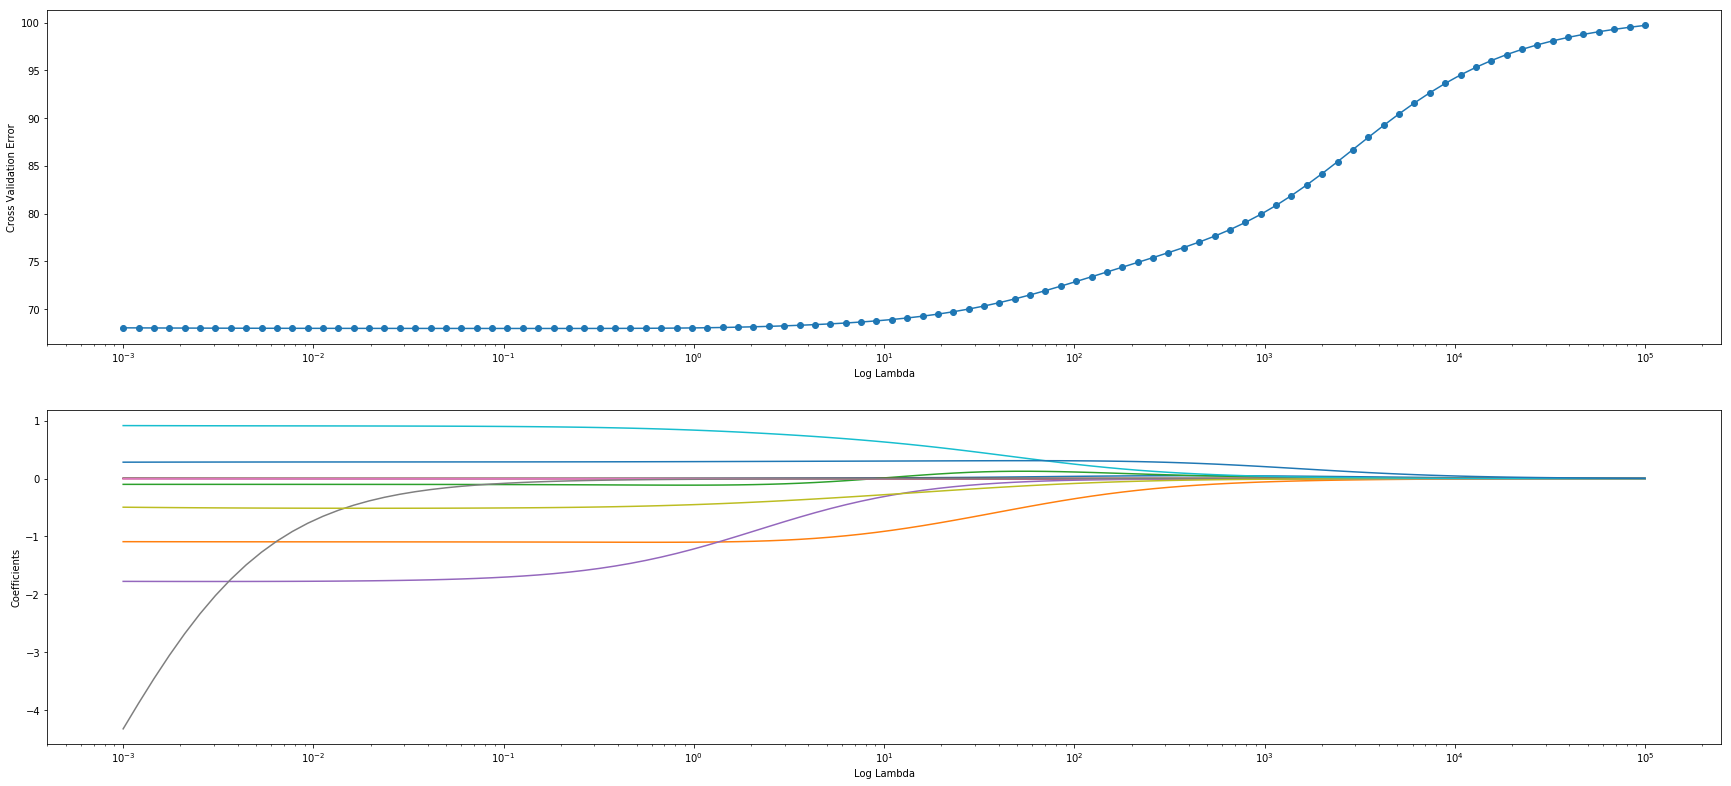

In [46]:
#Plot tuning parameters versus error and tuning parameters versus coefficient value
fig = plt.figure(figsize=(20*1.5,9*1.5))
fig.tight_layout()

rid = fig.add_subplot(211)
rid.scatter(ridge[3], ridge[2])
rid.plot(ridge[3], ridge[2])
rid.set_xscale('log')
rid.set_xlabel('Log Lambda')
rid.set_ylabel("Cross Validation Error")

rid_coeff = fig.add_subplot(212)
rid_coeff.set_xlabel('Log Lambda')
rid_coeff.set_ylabel("Coefficients")
for i in np.arange(1,12):
    rid_coeff.plot(ridge[3],ridge[4][:,i-1])
    rid_coeff.set_xscale('log')


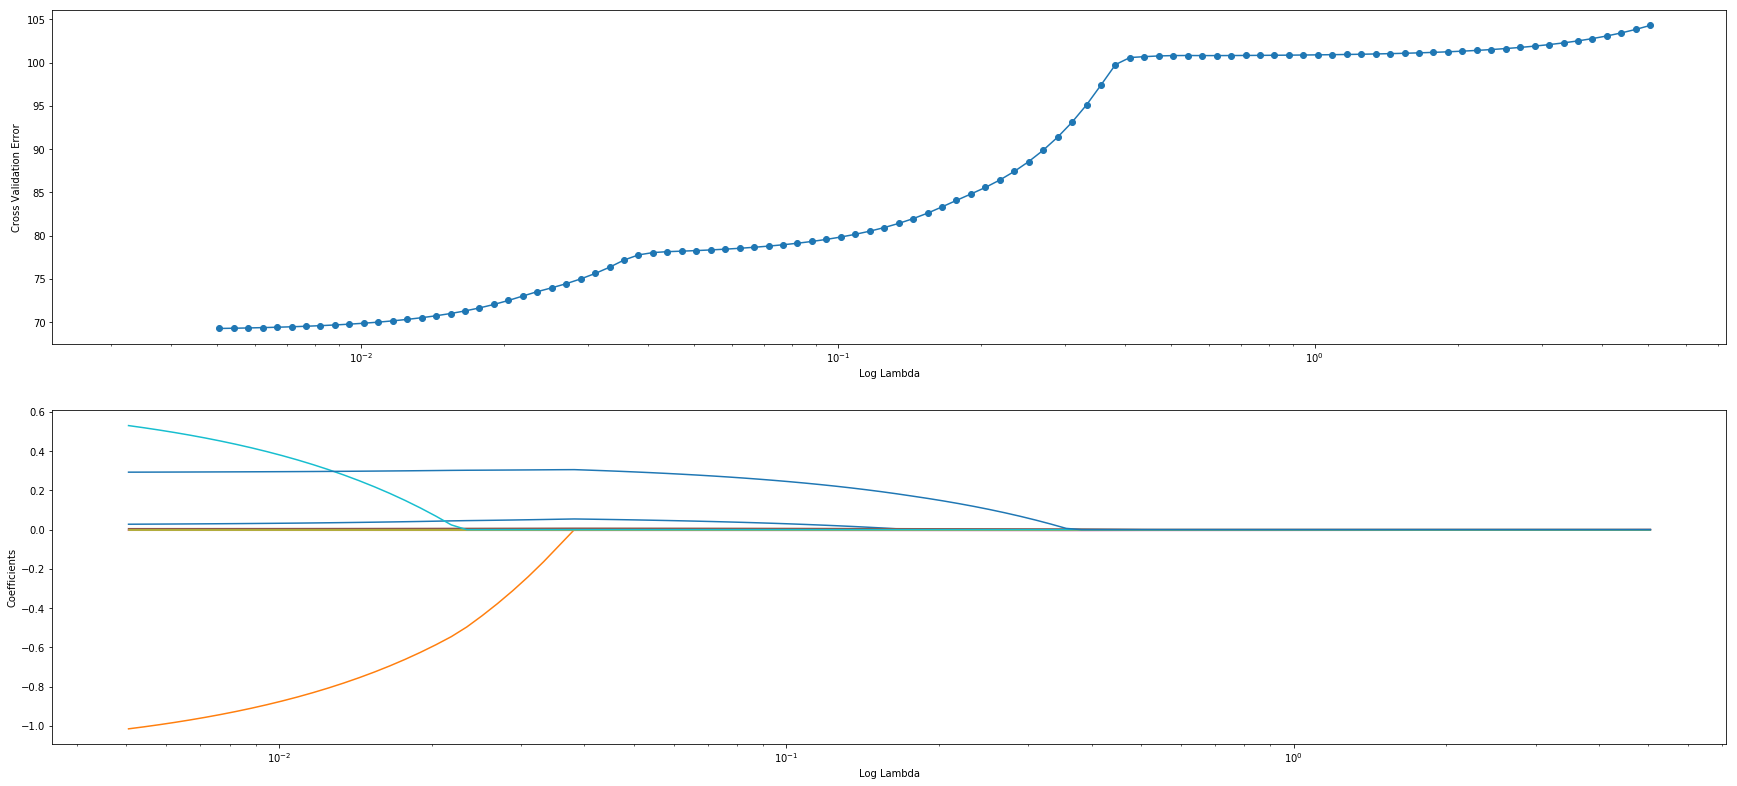

In [47]:
#Plot tuning parameters versus error and tuning parameters versus coefficient value
fig2 = plt.figure(figsize=(20*1.5,9*1.5))
fig2.tight_layout()

las = fig2.add_subplot(211)
las.scatter(lasso[3], lasso[2])
las.plot(lasso[3], lasso[2])
las.set_xscale('log')
las.set_xlabel('Log Lambda')
las.set_ylabel("Cross Validation Error")

las_coeff = fig2.add_subplot(212)
las_coeff.set_xlabel('Log Lambda')
las_coeff.set_ylabel("Coefficients")
for i in np.arange(1,12):
    las_coeff.plot(lasso[3],lasso[4][:,i-1])
    las_coeff.set_xscale('log')
    

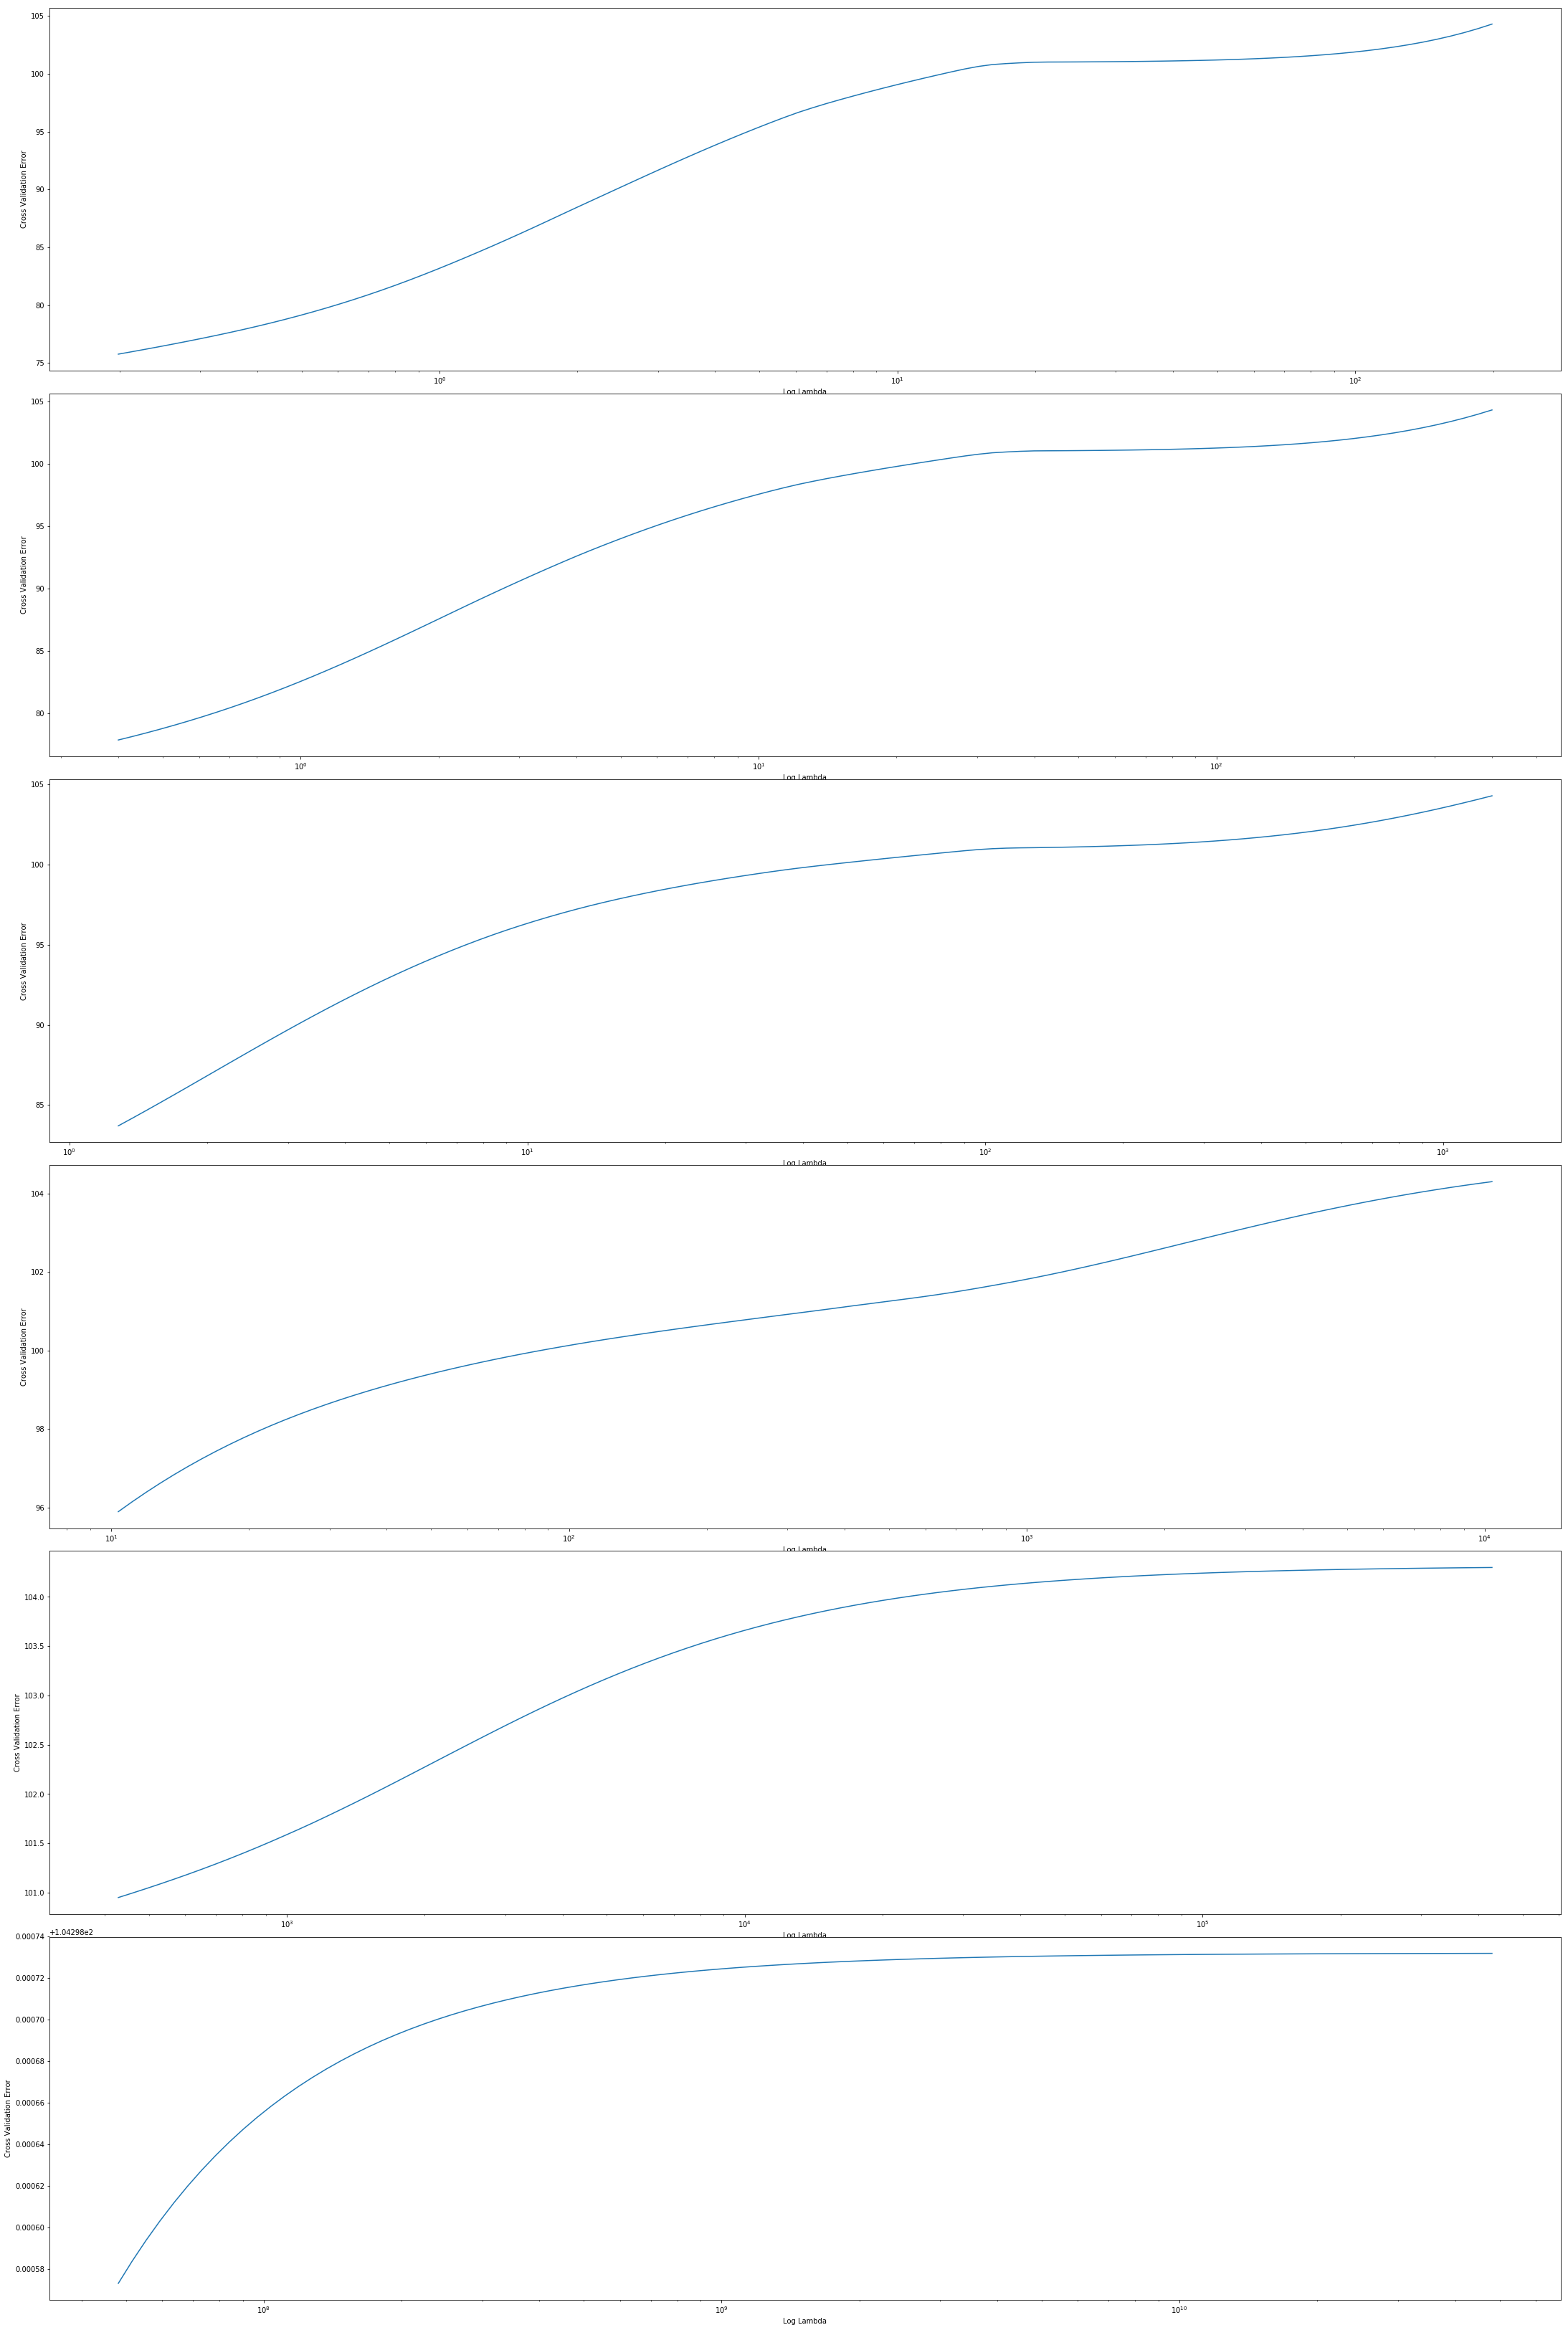

In [48]:
fig4,axs = plt.subplots(6,1,figsize = (20*1.5,30*1.5))
fig4.tight_layout()

axs = axs.ravel()
for i in np.arange(1,7):
    X = elastic[4][int(99/(7-i)),:]
    Y = elastic[3][int(99/(7-i)),:]
    axs[i-1].plot(X,Y)
    axs[i-1].set_xscale('log')
    axs[i-1].set_xlabel('Log Lambda')
    axs[i-1].set_ylabel("Cross Validation Error")

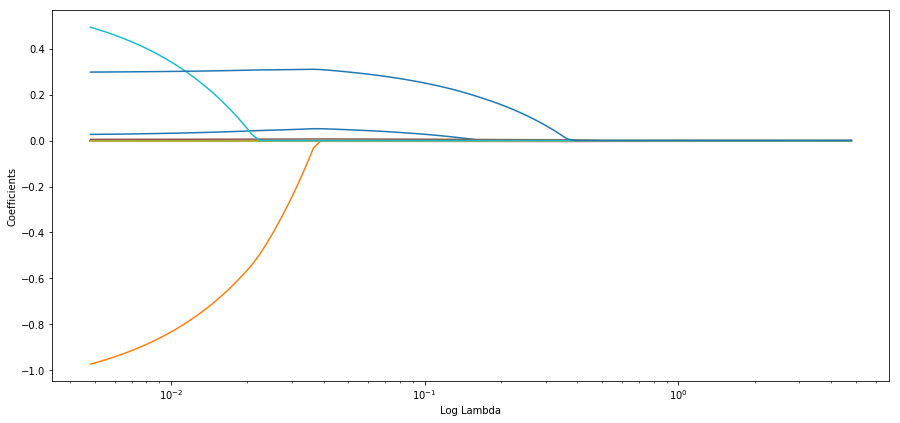

In [49]:
fig5 = plt.figure(figsize=(15,15))

elas_coeff = fig5.add_subplot(212)
elas_coeff.set_xlabel('Log Lambda')
elas_coeff.set_ylabel("Coefficients")
elas_coeff.plot(elastic[5],elastic[6][0])
elas_coeff.set_xscale('log')

### Part 2

In [27]:
sales_data = pd.read_csv('wholesale-customers.csv')
sales_data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
